# Challenge - Time Series Analysis
Using a different time series data set (either from FRED or elsewhere, go about the process of time series modeling. Specifically generate the following things:

- Plot the time series, along with any logical or necessary differences to get a stationary dataset
- Generate and interpret a PACF for the time series (and/or its differences)
- Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data
- Finally choose one specification and make the case for that as a logical model for your dataset.

This should come in the form of a notebook with the necessary prose to explain your process. Remember to use the tools of text, visuals, and analysis to tell a clear and concise story with your data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf, acf
from mdst import null_summary # mdst = my data science tools.

Data will be the USD/Euro exchange rate data set found here: https://fred.stlouisfed.org/

# Data Cleaning/Exploration

In [2]:
df = pd.read_csv('DEXUSEU.csv')
df.columns = ['date', 'price']
df.head()

,date,price
0,2014-01-27,1.3679
1,2014-01-28,1.3662
2,2014-01-29,1.3663
3,2014-01-30,1.3549
4,2014-01-31,1.3500


In [3]:
df.dtypes

date     object
price    object
dtype: object

In [4]:
# convert price column to numeric, fill with NaN if cell can't be converted
df.price = pd.to_numeric(df.price, errors='coerce')


In [5]:
null_summary(df)

total rows:  1305


,null_counts,pct_nulls,dtype
date,0,0,object
price,55,4.2146,float64


In [6]:
# impute null values as mean of surrounding values 
null_indices = list(df[df.price.isnull()].index)
for i in null_indices:
    step_up, step_down = 1, 1
    if i-1 in null_indices:
        step_up = 2
    if i+1 in null_indices:
        step_down = 2
    df.iloc[i, 1] = (df.iloc[i-step_up,1] + df.iloc[i+step_down,1])/2



In [7]:
null_summary(df)

total rows:  1305


,null_counts,pct_nulls,dtype
date,0,0,object
price,0,0,float64


In [8]:
df.index = pd.to_datetime(df.date)
del df['date']

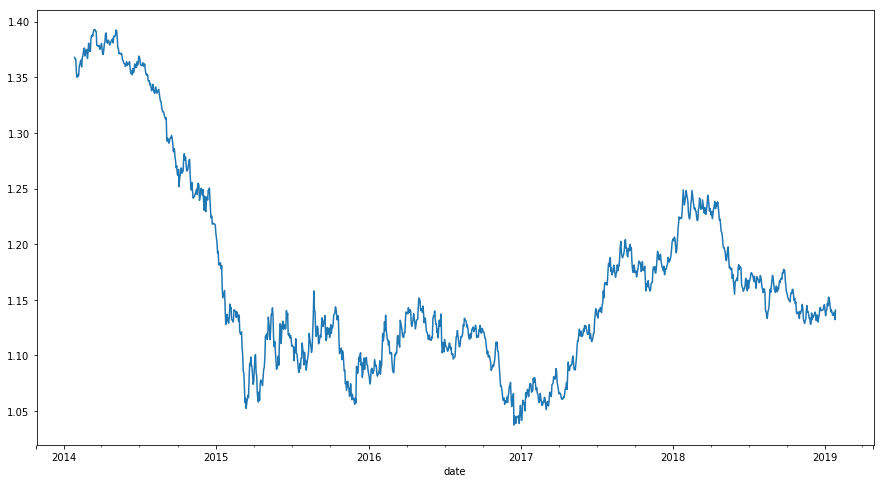

In [9]:
df.price.plot(figsize=(15,8))

Text(0.5, 1.0, 'PACF')

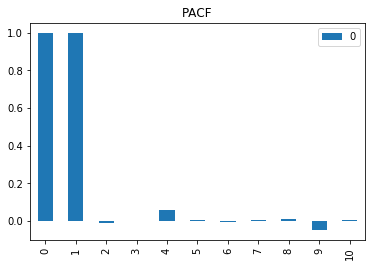

In [10]:
x_acf = pd.DataFrame(pacf(df.price, nlags=10))
x_acf.plot(kind='bar')
plt.title("PACF")

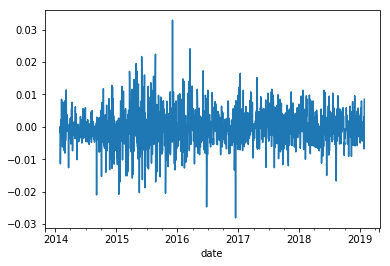

In [11]:
df.price.diff()[1:].plot()

Text(0.5, 1.0, 'PACF')

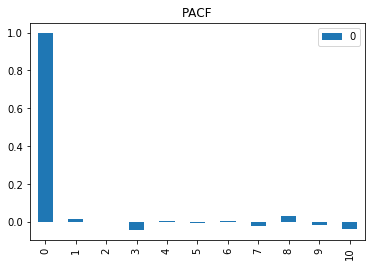

In [12]:
x_acf = pd.DataFrame(pacf(df.price.diff()[1:], nlags=10))
x_acf.plot(kind='bar')
plt.title("PACF")

# ARIMA Models

c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
c:\python37\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
c:\python37\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
c:\python37\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple seq

                                 ARMA Model Results                                
Dep. Variable:                  price   No. Observations:                      1305
Model:                     ARMA(1, 0)   Log Likelihood                     4850.170
Method:                       css-mle   S.D. of innovations 5231271781902980096.000
Date:                Tue, 19 Feb 2019   AIC                               -9694.341
Time:                        23:26:50   BIC                               -9678.819
Sample:                    01-27-2014   HQIC                              -9688.518
                         - 01-25-2019                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1246        nan        nan        nan         nan         nan
ar.L1.price     0.9960        nan        nan        nan         nan         nan
        

Text(0.5, 1.0, 'Histogram of Residuals')

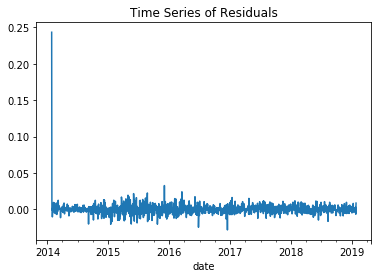

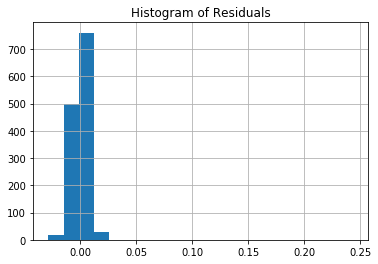

In [13]:
model = ARIMA(df.price, order=(1,0,0))
model_fit = model.fit(transparams=False)
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

Notes:
- arima model on data in dollars ended up with positive log likelihood and negative AIC. Not sure why? maybe some sort of rounding? (see cell below)
- errors for non stationary AR coefficients:
    - 1,1,1
    - 1,1,2
    - 2,1,2
    - 2,2,2 (error was did not converge)

## (1,1,1)

c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 1304
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4852.991
Method:                       css-mle   S.D. of innovations              0.006
Date:                Tue, 19 Feb 2019   AIC                          -9697.983
Time:                        23:26:51   BIC                          -9677.290
Sample:                    01-28-2014   HQIC                         -9690.220
                         - 01-25-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.000     -1.055      0.291      -0.000       0.000
ar.L1.D.price     0.0214      0.648      0.033      0.974      -1.249       1.292
ma.L1.D.price    -0.0040      0.648     

Text(0.5, 1.0, 'Histogram of Residuals')

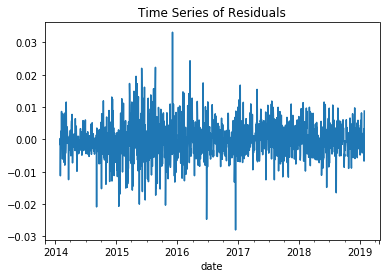

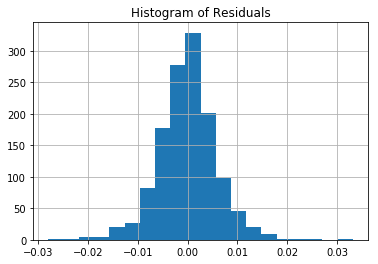

In [14]:
model = ARIMA(df.price, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

## (0,1,0)

c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 1304
Model:                 ARIMA(0, 1, 0)   Log Likelihood                4852.795
Method:                           css   S.D. of innovations              0.006
Date:                Tue, 19 Feb 2019   AIC                          -9701.590
Time:                        23:26:52   BIC                          -9691.244
Sample:                    01-28-2014   HQIC                         -9697.709
                         - 01-25-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.075      0.283      -0.000       0.000
Residuals Description
count    1.304000e+03
mean     2.146825e-10
std      5.857552e-03
min     -2.792577e-02
25%     -3.325767e-03

Text(0.5, 1.0, 'Histogram of Residuals')

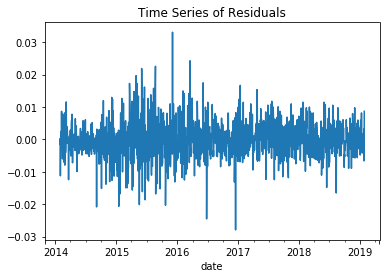

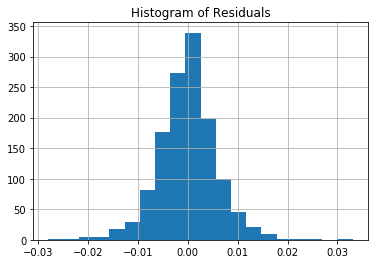

In [15]:
model = ARIMA(df.price, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

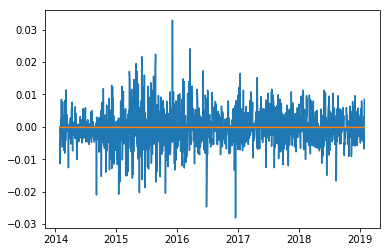

In [16]:
plt.plot(df.price.diff()[1:])
plt.plot(model_fit.predict())

## (0,2,0)

c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 1303
Model:                 ARIMA(0, 2, 0)   Log Likelihood                4408.965
Method:                           css   S.D. of innovations              0.008
Date:                Tue, 19 Feb 2019   AIC                          -8813.930
Time:                        23:26:54   BIC                          -8803.585
Sample:                    01-29-2014   HQIC                         -8810.049
                         - 01-25-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.828e-06      0.000      0.034      0.973      -0.000       0.000
Residuals Description
count    1.303000e+03
mean     2.569097e-10
std      8.211188e-03
min     -3.940783e-02
25%     -4.557828e-03

Text(0.5, 1.0, 'Histogram of Residuals')

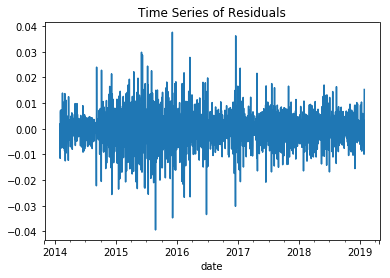

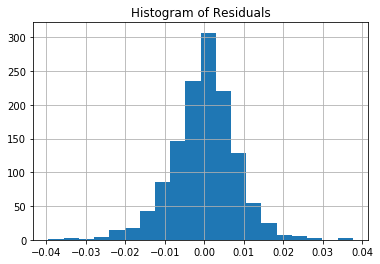

In [17]:
model = ARIMA(df.price, order=(0,2,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

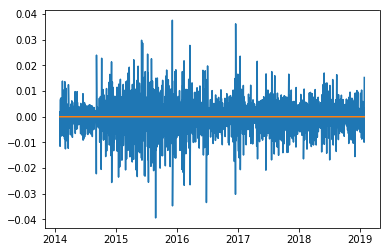

In [18]:
plt.plot(df.price.diff().diff()[1:])
plt.plot(model_fit.predict())

## (1,2,2)

c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.price   No. Observations:                 1303
Model:                 ARIMA(1, 2, 2)   Log Likelihood                4846.599
Method:                       css-mle   S.D. of innovations              0.006
Date:                Tue, 19 Feb 2019   AIC                          -9683.197
Time:                        23:26:57   BIC                          -9657.335
Sample:                    01-29-2014   HQIC                         -9673.495
                         - 01-25-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.976e-07   4.49e-07      1.332      0.183   -2.82e-07    1.48e-06
ar.L1.D2.price    -0.9380      0.047    -20.071      0.000      -1.030      -0.846
ma.L1.D2.price    -0.0725      0.052

Text(0.5, 1.0, 'Histogram of Residuals')

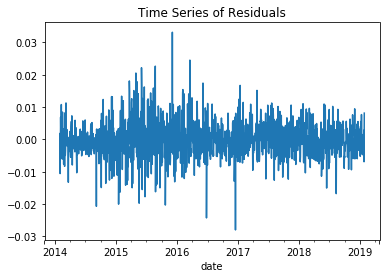

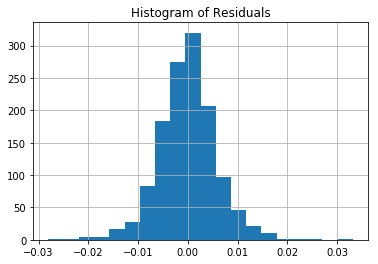

In [19]:
model = ARIMA(df.price, order=(1,2,2))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

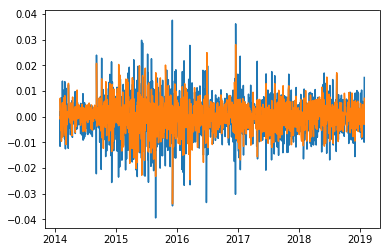

In [20]:
plt.plot(df.price.diff().diff()[2:])
plt.plot(model_fit.predict())

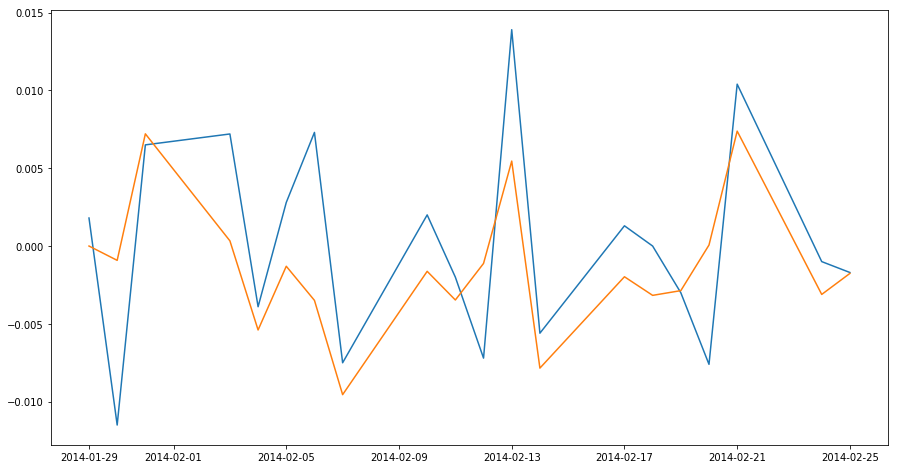

In [21]:
plt.figure(figsize=(15,8))
plt.plot(df.price.diff().diff()[2:22])
plt.plot(model_fit.predict()[:20])

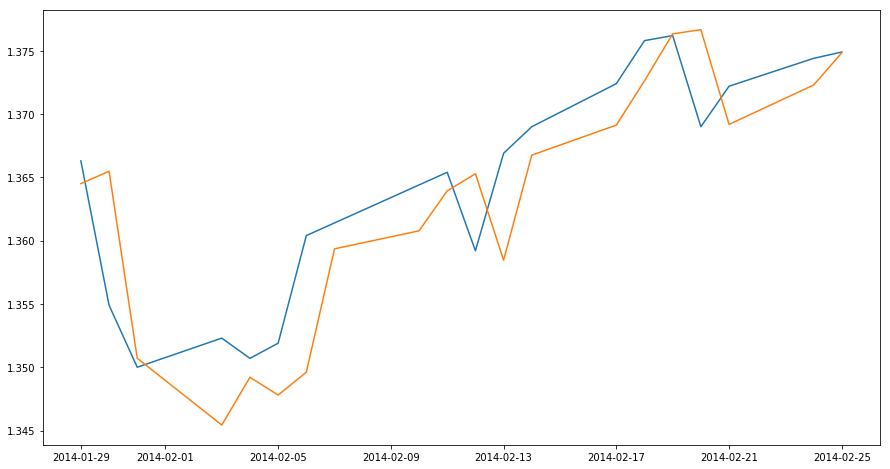

In [22]:
plt.figure(figsize=(15,8))
plt.plot(df.price[2:22])
plt.plot(model_fit.predict(typ='levels')[:20])

## (1,1,0)

c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 1304
Model:                 ARIMA(1, 1, 0)   Log Likelihood                4852.991
Method:                       css-mle   S.D. of innovations              0.006
Date:                Tue, 19 Feb 2019   AIC                          -9699.983
Time:                        23:26:58   BIC                          -9684.463
Sample:                    01-28-2014   HQIC                         -9694.161
                         - 01-25-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.000     -1.055      0.291      -0.000       0.000
ar.L1.D.price     0.0174      0.028      0.627      0.531      -0.037       0.072
                                    Root

Text(0.5, 1.0, 'Histogram of Residuals')

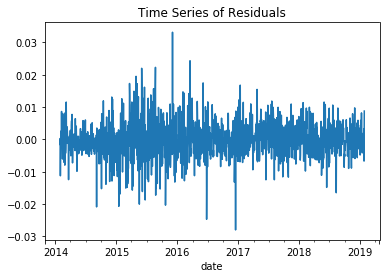

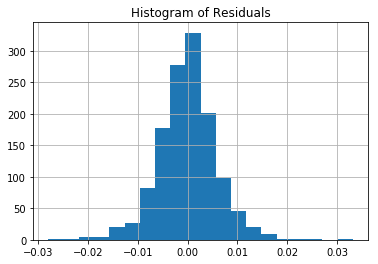

In [23]:
model = ARIMA(df.price, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

residuals = pd.DataFrame(model_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

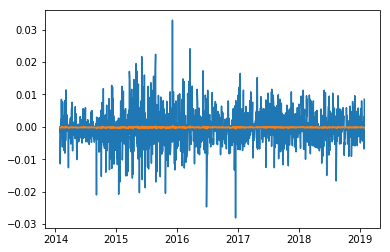

In [24]:
plt.plot(df.price.diff()[1:])
plt.plot(model_fit.predict())

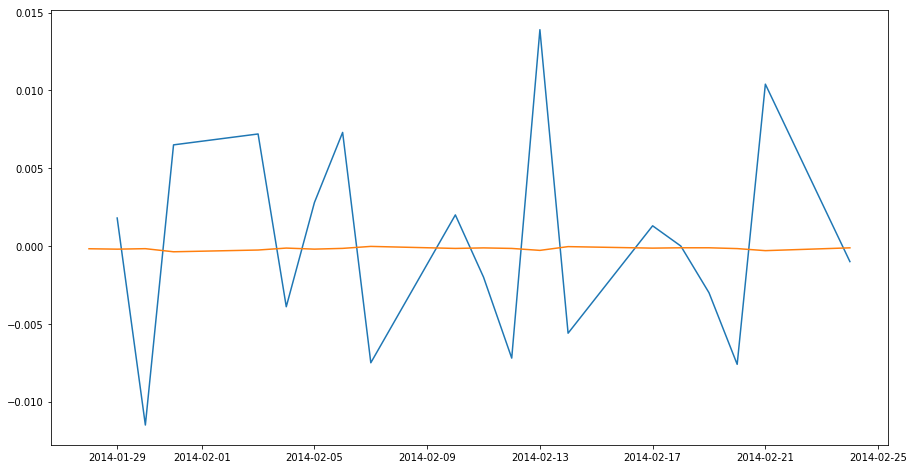

In [25]:
plt.figure(figsize=(15,8))
plt.plot(df.price.diff().diff()[1:21])
plt.plot(model_fit.predict()[:20])

# Conclusion

Model Orders:
- 010
    - LL: 4853
    - AIC: -9701
- 110
    - LL: 4853
    - AIC -9670:
- 111
    - LL: 4853
    - AIC: -9698
- 020
    - LL: 4409
    - AIC: -8813
- 122
    - LL: 4846
    - AIC: -9683

None of these models are very good. The best one was order (0,1,0) and all it does is predict 2 hundredths of a penny below the previous days price.